In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel

from scipy.stats import pearsonr

from langdetect import detect
import langid

pd.set_option('display.max_colwidth', 50)

WELFake Dataset

In [164]:
# Load data from CSV file
df = pd.read_csv('WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


1    37106
0    35028
Name: label, dtype: int64


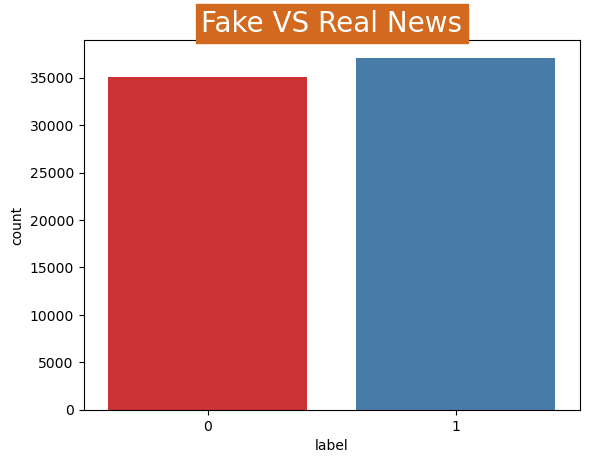

In [165]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [7]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [167]:
check(df)

,column,dtypes,nunique,sum_null
0,Unnamed: 0,int64,72134,0
1,title,object,62347,558
2,text,object,62718,39
3,label,int64,2,0


In [168]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [169]:
# delete missing data
#df.dropna(inplace=True)
df.fillna('', inplace=True)

1    37106
0    35028
Name: label, dtype: int64


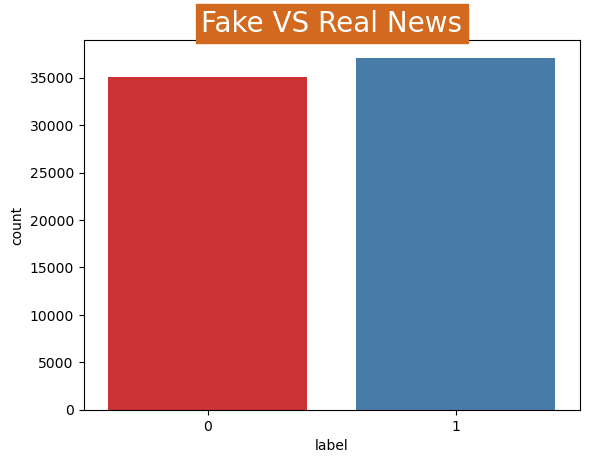

In [170]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [171]:
# check for duplicate rows
df.duplicated().sum()

8456

In [172]:
# delete duplicate rows
df.drop_duplicates(inplace=True)

In [173]:
check(df)

,column,dtypes,nunique,sum_null
0,title,object,62348,0
1,text,object,62719,0
2,label,int64,2,0


In [174]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


0    34791
1    28887
Name: label, dtype: int64


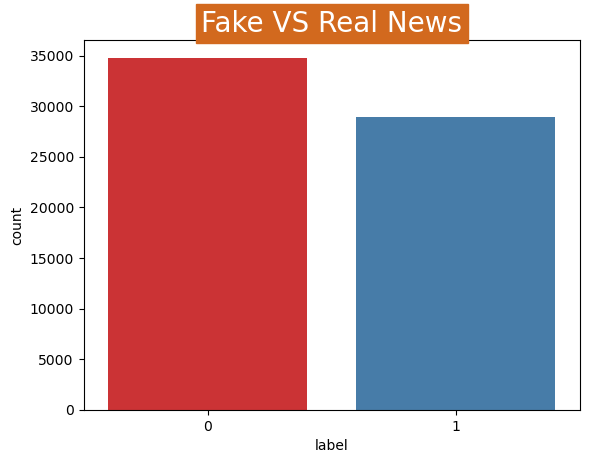

In [175]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [176]:
df['text']=df['title']+' '+df['text']

df.drop(columns=['title'],inplace=True)

In [177]:
# Create a new column to store the language label for each article
def detect_language(text):
    if isinstance(text, str) and len(text) > 50:
        return langid.classify(text)[0]
    else:
        return 'unknown'

df['language'] = df['text'].apply(detect_language)

In [178]:
counts = df['language'].value_counts()

print(counts)

en         62960
ru           157
es           143
unknown      129
de            94
fr            68
ar            22
mt            12
da            10
it             8
pt             8
la             8
tr             7
rw             6
no             5
hr             5
pl             4
nl             4
id             2
sw             2
bn             2
he             2
ur             2
el             2
zh             2
fo             2
si             1
sv             1
lt             1
tl             1
an             1
eo             1
ga             1
et             1
lv             1
az             1
ro             1
nn             1
Name: language, dtype: int64


In [179]:
# Check articles below 50 chars or unknown language
df_language = df[df['language'] == 'unknown']

print(df_language)

                                                  text  label language
1       Did they post their votes for Hillary already?      1  unknown
185                                               Cool      1  unknown
358                                    Obamas blunder.      1  unknown
1269                   That would be unconstitutional.      1  unknown
1942                  Graphic: Supreme Court roundup        0  unknown
...                                                ...    ...      ...
70866        Goodbye John Kirby – we won’t miss you…        1  unknown
70911                                  Boycott the NFL      1  unknown
71379                                     Ludicrous...      1  unknown
71518                  LIVE FEED: INAUGURATION 2017!        1  unknown
71734           Hmm, free college, now that's an idea.      1  unknown

[129 rows x 3 columns]


In [180]:
# Filter out articles that are not in English
df = df[(df['language'] == 'en')]

0    34783
1    28177
Name: label, dtype: int64


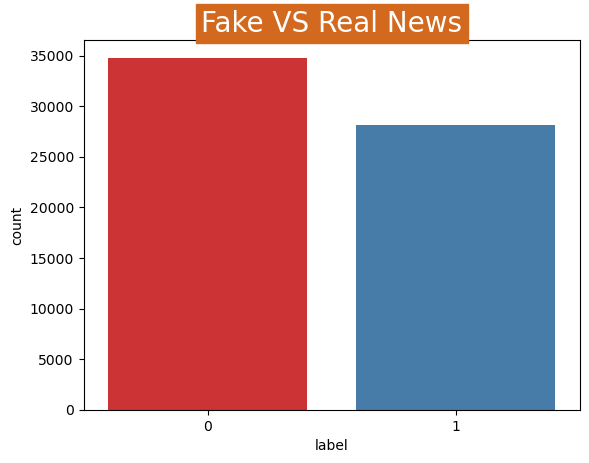

In [181]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [182]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,62960,0
1,label,int64,2,0
2,language,object,1,0


In [183]:
# Save the merged data frame to a CSV file
df.to_csv('WELFake_Dataset_cleaned.csv', index=False)

Steven Kaggle Dataset

In [184]:
# Read the fake news CSV file
fake_news_df = pd.read_csv('DataSet_Misinfo_FAKE.csv')

# Read the real news CSV file
real_news_df = pd.read_csv('DataSet_Misinfo_TRUE.csv')

# Add a column to each data frame indicating the type of news
fake_news_df['label'] = 0
real_news_df['label'] = 1

# Merge the two data frames into one
df = pd.concat([fake_news_df, real_news_df])

df.head()
# Save the merged data frame to a CSV file
#merged_df.to_csv('DataSet_Misinfo_Steven.csv', index=False)

,Unnamed: 0,text,label
0,0,Donald Trump just couldn t wish all Americans ...,0
1,1,House Intelligence Committee Chairman Devin Nu...,0
2,2,"On Friday, it was revealed that former Milwauk...",0
3,3,"On Christmas day, Donald Trump announced that ...",0
4,4,Pope Francis used his annual Christmas Day mes...,0


0    43642
1    34975
Name: label, dtype: int64


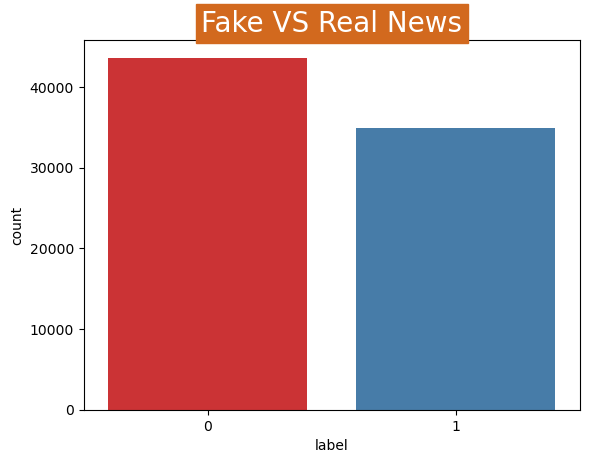

In [185]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [186]:
check(df)

,column,dtypes,nunique,sum_null
0,Unnamed: 0,int64,44398,0
1,text,object,68604,29
2,label,int64,2,0


In [187]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [188]:
# delete missing data
#df.dropna(inplace=True)
df.fillna('', inplace=True)

0    43642
1    34975
Name: label, dtype: int64


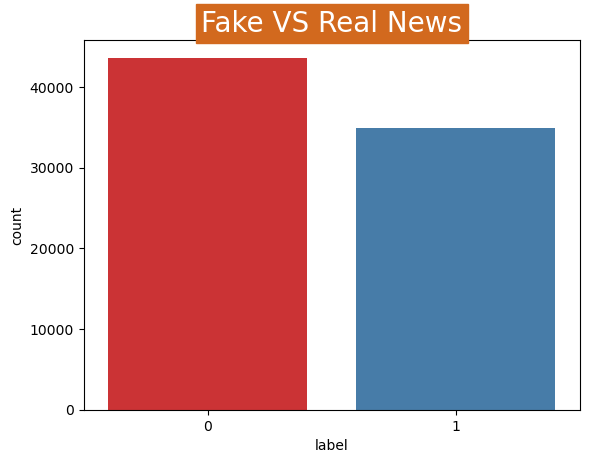

In [189]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [190]:
# check for duplicate rows
df.duplicated().sum()

10012

In [191]:
# delete duplicate rows
df.drop_duplicates(inplace=True)

In [192]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,68605,0
1,label,int64,2,0


In [193]:
df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


1    34527
0    34078
Name: label, dtype: int64


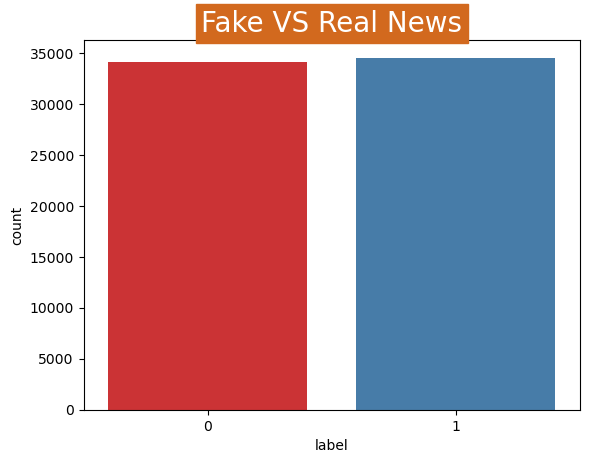

In [194]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [195]:
# Create a new column to store the language label for each article
def detect_language(text):
    if isinstance(text, str) and len(text) > 50:
        return langid.classify(text)[0]
    else:
        return 'unknown'

df['language'] = df['text'].apply(detect_language)

In [196]:
counts = df['language'].value_counts()

print(counts)

en         67654
unknown      449
ru           157
es           141
de            93
fr            31
ar            22
pt             8
tr             7
la             6
it             5
mt             4
pl             3
nl             3
rw             2
si             2
ur             2
no             2
el             2
an             1
ga             1
id             1
fo             1
ro             1
vi             1
zh             1
da             1
nn             1
ms             1
tl             1
sv             1
Name: language, dtype: int64


In [197]:
# Check articles below 50 chars or unknown language
df_language = df[df['language'] == 'unknown']

print(df_language)

                                                 text  label language
11115                                          Enjoy:      0  unknown
11243     https://www.youtube.com/watch?v=cJZFepSvxzM      0  unknown
11273     https://www.youtube.com/watch?v=-7Tn4gi_Os8      0  unknown
11291     https://www.youtube.com/watch?v=SH0pRtK9sAE      0  unknown
11292     https://www.youtube.com/watch?v=DRLVvYzG46w      0  unknown
...                                               ...    ...      ...
18686  Tanzania shut down another newspaper on Friday      1  unknown
21155                 Around 120,000 displaced people      1  unknown
24978                                             No.      1  unknown
30716                                   advertisement      1  unknown
32902     Should the U.S. Continue to Support Israel?      1  unknown

[449 rows x 3 columns]


In [198]:
# Filter out articles that are not in English
df = df[(df['language'] == 'en')]

1    34497
0    33157
Name: label, dtype: int64


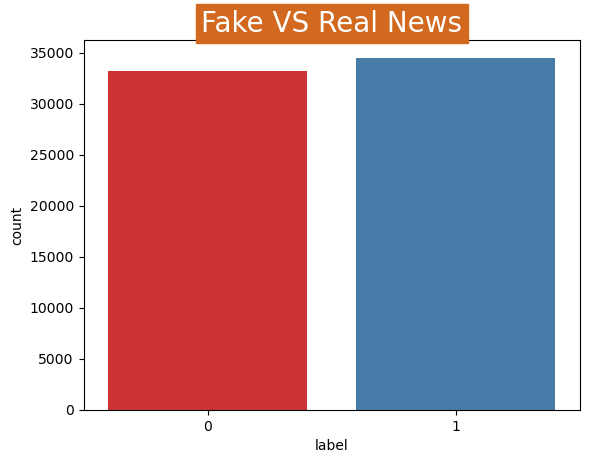

In [199]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [200]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,67654,0
1,label,int64,2,0
2,language,object,1,0


In [201]:
df.to_csv('DataSet_Misinfo_Steven_cleaned.csv', index=False)

Covid Fake News COSTRAINT

In [220]:
costraint_test_df = pd.read_csv('COSTRAINT_COVID_test.csv')

costraint_train_df = pd.read_csv('COSTRAINT_COVID_train.csv')

costraint_val_df = pd.read_csv('COSTRAINT_COVID_val.csv')

# Merge the two data frames into one
df = pd.concat([costraint_test_df, costraint_train_df,costraint_val_df])

df = df.rename(columns={'tweet': 'text'})

# Replace 'real' with 1 and 'fake' with 0
df['label'] = df['label'].replace({'real': 1, 'fake': 0})

df.head()
# Save the merged data frame to a CSV file
#merged_df.to_csv('DataSet_Misinfo_Steven.csv', index=False)

,id,text,label
0,1,Our daily update is published. States reported...,1
1,2,Alfalfa is the only cure for COVID-19.,0
2,3,President Trump Asked What He Would Do If He W...,0
3,4,States reported 630 deaths. We are still seein...,1
4,5,This is the sixth time a global health emergen...,1


1    5600
0    5100
Name: label, dtype: int64


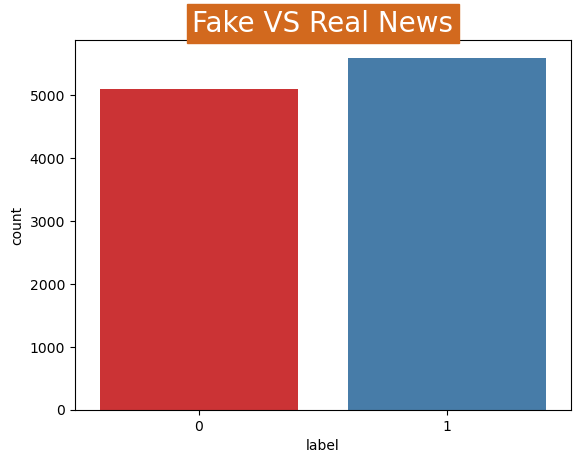

In [221]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [222]:
check(df)

,column,dtypes,nunique,sum_null
0,id,int64,6420,0
1,text,object,10699,0
2,label,int64,2,0


In [223]:
df.drop(columns=['id'],inplace=True)

In [224]:
# delete missing data
#df.dropna(inplace=True)
df.fillna('', inplace=True)

1    5600
0    5100
Name: label, dtype: int64


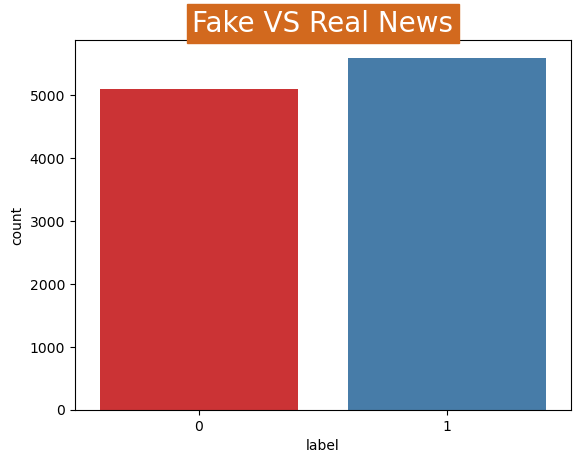

In [225]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [226]:
# check for duplicate rows
df.duplicated().sum()

1

In [227]:
# delete duplicate rows
df.drop_duplicates(inplace=True)

In [228]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,10699,0
1,label,int64,2,0


In [229]:
df.head()

,text,label
0,Our daily update is published. States reported...,1
1,Alfalfa is the only cure for COVID-19.,0
2,President Trump Asked What He Would Do If He W...,0
3,States reported 630 deaths. We are still seein...,1
4,This is the sixth time a global health emergen...,1


1    5599
0    5100
Name: label, dtype: int64


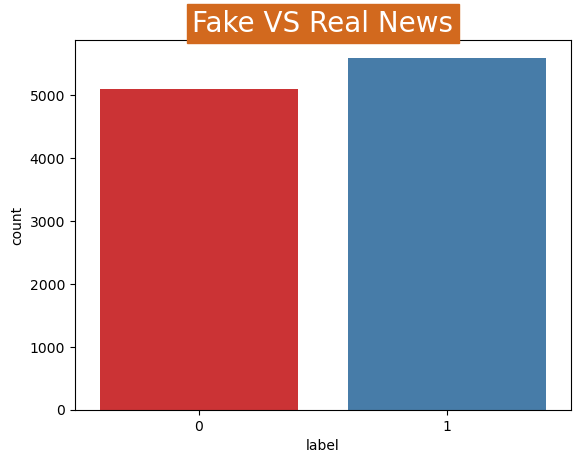

In [230]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [231]:
# Create a new column to store the language label for each article
def detect_language(text):
    if isinstance(text, str):
        return langid.classify(text)[0]
    else:
        return 'unknown'

df['language'] = df['text'].apply(detect_language)

In [232]:
counts = df['language'].value_counts()

print(counts)

en    10478
la       63
zh       34
de       14
fr       10
es        9
pt        9
nl        8
sw        8
it        6
no        5
mt        5
rw        5
af        4
da        4
id        3
tl        3
jv        2
lb        2
ca        2
hi        2
eu        2
kn        2
ga        2
pl        2
gl        1
fi        1
et        1
eo        1
sv        1
oc        1
lt        1
br        1
lv        1
qu        1
xh        1
is        1
zu        1
ro        1
sl        1
Name: language, dtype: int64


In [233]:
# Check articles below 50 chars or unknown language
df_language = df[df['language'] == 'unknown']

print(df_language)

Empty DataFrame
Columns: [text, label, language]
Index: []


In [234]:
# Filter out articles that are not in English
df = df[(df['language'] == 'en')]

1    5493
0    4985
Name: label, dtype: int64


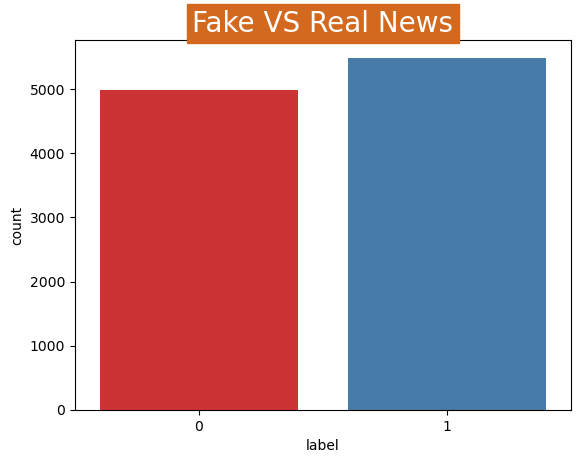

In [235]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [236]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,10478,0
1,label,int64,2,0
2,language,object,1,0


In [237]:
df.to_csv('COSTRAINT_COVID_cleaned.csv', index=False)

Final English Dataset

In [3]:
WELfake_df = pd.read_csv('WELFake_Dataset_cleaned.csv')

Misinfo_df = pd.read_csv('DataSet_Misinfo_Steven_cleaned.csv')

COSTRAINT_COVID_df = pd.read_csv('COSTRAINT_COVID_cleaned.csv')

In [4]:
# Create a new column for each dataset
WELfake_df['dataset'] = 'WELFake'
Misinfo_df['dataset'] = 'Misinfo_Steven'
COSTRAINT_COVID_df['dataset'] = 'CONSTRAINT_Covid'

In [7]:
COSTRAINT_COVID_df.head()

,text,label,language,dataset
0,Our daily update is published. States reported...,1,en,CONSTRAINT_Covid
1,Alfalfa is the only cure for COVID-19.,0,en,CONSTRAINT_Covid
2,President Trump Asked What He Would Do If He W...,0,en,CONSTRAINT_Covid
3,States reported 630 deaths. We are still seein...,1,en,CONSTRAINT_Covid
4,This is the sixth time a global health emergen...,1,en,CONSTRAINT_Covid


In [8]:
# Merge the two data frames into one
final_df = pd.concat([Misinfo_df, WELfake_df, COSTRAINT_COVID_df])

# Save the merged data frame to a CSV file
final_df.to_csv('Final_Dataset_with_dataset_reference.csv', index=False)

In [9]:
# Load data from CSV file
import pandas as pd
df = pd.read_csv('Final_Dataset_with_dataset_reference.csv')
df.head()

,text,label,language,dataset
0,Donald Trump just couldn t wish all Americans ...,0,en,Misinfo_Steven
1,House Intelligence Committee Chairman Devin Nu...,0,en,Misinfo_Steven
2,"On Friday, it was revealed that former Milwauk...",0,en,Misinfo_Steven
3,"On Christmas day, Donald Trump announced that ...",0,en,Misinfo_Steven
4,Pope Francis used his annual Christmas Day mes...,0,en,Misinfo_Steven


0    72925
1    68167
Name: label, dtype: int64


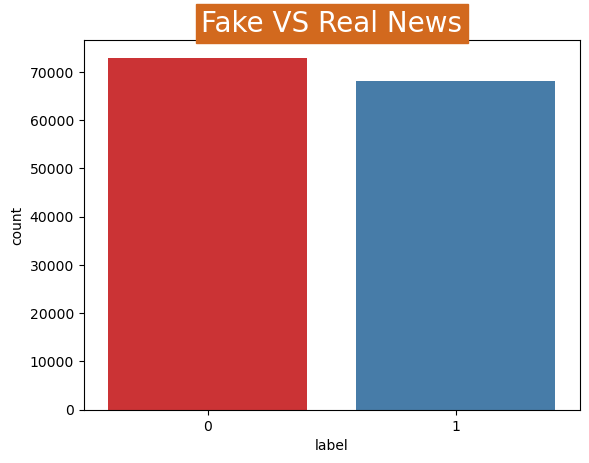

In [10]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [11]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,141092,0
1,label,int64,2,0
2,language,object,1,0
3,dataset,object,3,0


In [12]:
#df.drop(columns=['Unnamed: 0'],inplace=True)

In [13]:
# delete missing data
#df.dropna(inplace=True)
df.fillna('', inplace=True)

0    72925
1    68167
Name: label, dtype: int64


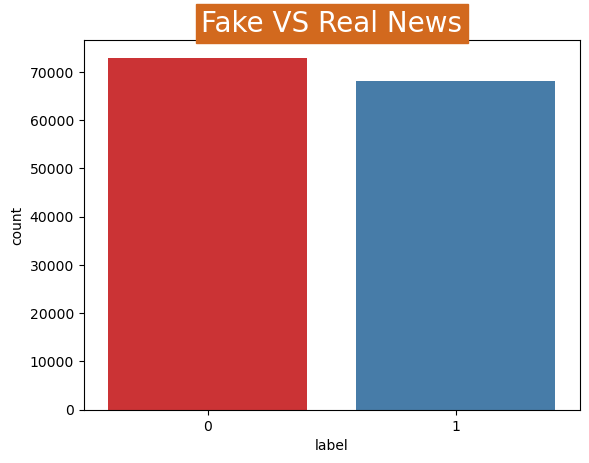

In [14]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [15]:
# check for duplicate rows
df.duplicated().sum()

0

In [16]:
# delete duplicate rows
df.drop_duplicates(inplace=True)

In [17]:
check(df)

,column,dtypes,nunique,sum_null
0,text,object,141092,0
1,label,int64,2,0
2,language,object,1,0
3,dataset,object,3,0


In [18]:
df.head()

,text,label,language,dataset
0,Donald Trump just couldn t wish all Americans ...,0,en,Misinfo_Steven
1,House Intelligence Committee Chairman Devin Nu...,0,en,Misinfo_Steven
2,"On Friday, it was revealed that former Milwauk...",0,en,Misinfo_Steven
3,"On Christmas day, Donald Trump announced that ...",0,en,Misinfo_Steven
4,Pope Francis used his annual Christmas Day mes...,0,en,Misinfo_Steven


0    72925
1    68167
Name: label, dtype: int64


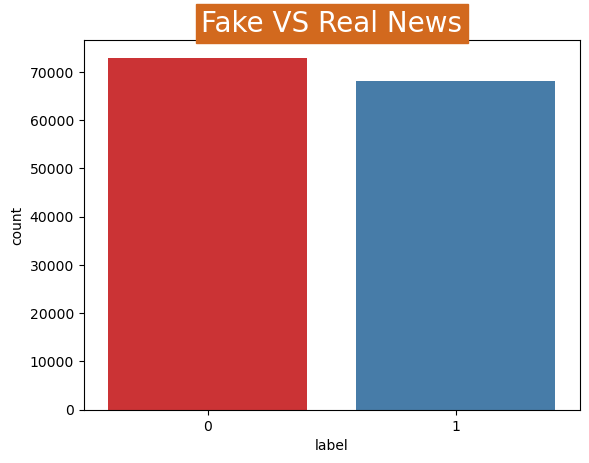

In [19]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = df['label'].value_counts()

print(counts)

In [20]:
# Create a new column to store the language label for each article
def detect_language(text):
    if isinstance(text, str):
        return langid.classify(text)[0]
    else:
        return 'unknown'

df['language'] = df['text'].apply(detect_language)

In [21]:
counts = df['language'].value_counts()

print(counts)

en    141092
Name: language, dtype: int64


In [22]:
# Check articles below 50 chars or unknown language
df_language = df[df['language'] == 'unknown']

print(df_language)

Empty DataFrame
Columns: [text, label, language, dataset]
Index: []


In [23]:
# Filter out articles that are not in English
df = df[(df['language'] == 'en')]

0    72925
1    68167
Name: label, dtype: int64


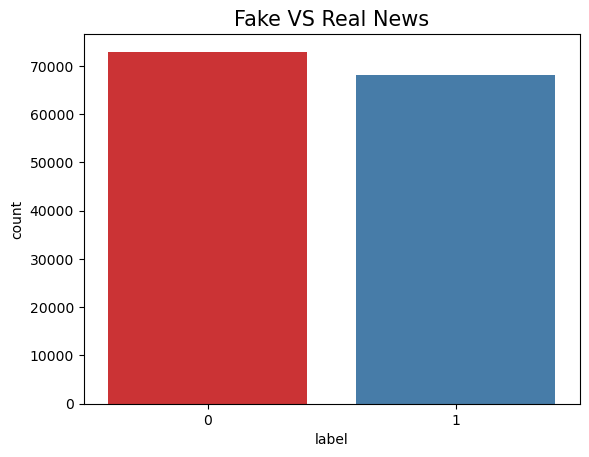

In [55]:
chart=sns.countplot(x='label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='15',
          color='black')

counts = df['label'].value_counts()

print(counts)

In [25]:
df.drop(columns=['language'],inplace=True)

check(df)

,column,dtypes,nunique,sum_null
0,text,object,141092,0
1,label,int64,2,0
2,dataset,object,3,0


In [26]:
df.to_csv('Final_dataset_english.csv', index=False)